# 7. Implementing an autoregressive Seq2Seq model

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (05/03/2024)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Torch (tested on v2.0.1+cu118)

In [51]:
import pandas as pd

# Relative path to the CSV
csv_path = '../dataset/train/DailyDelhiClimateTrain.csv'

# Load the dataset
df = pd.read_csv(csv_path)

# Quick look at the data
print(df.head())


         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [52]:
df[:15]

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


In [53]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Load the multivariate CSV
df = pd.read_csv('../dataset/train/DailyDelhiClimateTrain.csv')

# Drop the 'date' column and convert the rest to numpy
data = df.drop(columns=['date']).values.astype(np.float32)

# Sequence and future steps
seq_length = 115
future_steps = 115  # 5 steps

torch.set_printoptions(precision=4, sci_mode=False)

# Custom Dataset
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, future_steps):
        self.data = data
        self.seq_length = seq_length
        self.future_steps = future_steps

    def __len__(self):
        # Must have enough room for input + future
        return len(self.data) - self.seq_length - self.future_steps + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_length]
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.future_steps]
        return torch.tensor(x).float(), torch.tensor(y).float()

# Create dataset and dataloader
dataset = MultivariateTimeSeriesDataset(data, seq_length, future_steps)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Visualize a sample
sample = next(iter(dataloader))
input_sample, output_sample = sample
print("Input shape:", input_sample.shape)   # [64, 10, 4]
print("Output shape:", output_sample.shape) # [64, 5, 4]


Input shape: torch.Size([64, 115, 4])
Output shape: torch.Size([64, 115, 4])


In [54]:
dataset[0]

(tensor([[   10.0000,    84.5000,     0.0000,  1015.6667],
         [    7.4000,    92.0000,     2.9800,  1017.8000],
         [    7.1667,    87.0000,     4.6333,  1018.6667],
         [    8.6667,    71.3333,     1.2333,  1017.1667],
         [    6.0000,    86.8333,     3.7000,  1016.5000],
         [    7.0000,    82.8000,     1.4800,  1018.0000],
         [    7.0000,    78.6000,     6.3000,  1020.0000],
         [    8.8571,    63.7143,     7.1429,  1018.7143],
         [   14.0000,    51.2500,    12.5000,  1017.0000],
         [   11.0000,    62.0000,     7.4000,  1015.6667],
         [   15.7143,    51.2857,    10.5714,  1016.1429],
         [   14.0000,    74.0000,    13.2286,  1015.5714],
         [   15.8333,    75.1667,     4.6333,  1013.3333],
         [   12.8333,    88.1667,     0.6167,  1015.1667],
         [   14.7143,    71.8571,     0.5286,  1015.8571],
         [   13.8333,    86.6667,     0.0000,  1016.6667],
         [   16.5000,    80.8333,     5.2500,  1015.8333

### Imports and CUDA

In [55]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [56]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Generating a synthetic dataset

The code below will generate a synthetic dataset. Just like before it boils down to predicting the next values of a sinsusoid curve of some sort.

This time however, at each time $ t $, the model will get to see the last five values as inputs $ (x_{t-4}, x_{t-3}, x_{t-2}, x_{t-1}, x_{t}) $ and will attempt to predict the next five values $ (x_{t+1}, x_{t+2}, x_{t+3}, x_{t+4}, x_{t+5}) $.

The dataset and dataloaders are generated below.

In [57]:
# Our function to generate synthetic data
def generate_data(seq_length, num_samples):
    x = np.linspace(0, 2 * np.pi, seq_length + 1)
    sine_wave_sequences = np.sin(x)[:-1]
    return np.array([sine_wave_sequences for _ in range(num_samples)])

In [58]:
# Input sequence length
seq_length = 10
# Number of samples in the dataset
num_samples = 1000
# Generate dataset
data = generate_data(seq_length, num_samples)

print(data)

[[ 0.          0.58778525  0.95105652 ... -0.95105652 -0.95105652
  -0.58778525]
 [ 0.          0.58778525  0.95105652 ... -0.95105652 -0.95105652
  -0.58778525]
 [ 0.          0.58778525  0.95105652 ... -0.95105652 -0.95105652
  -0.58778525]
 ...
 [ 0.          0.58778525  0.95105652 ... -0.95105652 -0.95105652
  -0.58778525]
 [ 0.          0.58778525  0.95105652 ... -0.95105652 -0.95105652
  -0.58778525]
 [ 0.          0.58778525  0.95105652 ... -0.95105652 -0.95105652
  -0.58778525]]


In [59]:
class SineDataset(Dataset):
    def __init__(self, data, future_steps):
        self.data = data
        self.future_steps = future_steps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx, :self.future_steps]
        y = self.data[idx, self.future_steps:]
        # Add an extra dimension to match (sequence_length, input_size)
        return torch.from_numpy(x).unsqueeze(-1).float(), torch.from_numpy(y).unsqueeze(-1).float()

In [60]:
# Define future steps to predict
future_steps = seq_length//2 # This is 5

# Create dataset and dataloader
dataset = SineDataset(data, future_steps)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [61]:
# Draw a single sample to see what it looks like
sample = next(iter(dataset))
input, output = sample
print(input)
print(output)

tensor([[0.0000],
        [0.5878],
        [0.9511],
        [0.9511],
        [0.5878]])
tensor([[     0.0000],
        [    -0.5878],
        [    -0.9511],
        [    -0.9511],
        [    -0.5878]])


### Our encoder model

The EncoderRNN below processes input sequences through an LSTM. It is designed to capture the temporal dependencies in the data.
Only the final hidden states are returned, encapsulating the learned representation of the entire sequence. This encoder can be used in sequence-to-sequence models, where its hidden state initializes the decoder to generate outputs based on the input sequence.

It uses several layers of LSTM and possibly dropout.

In [62]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1, dropout = 0.0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = num_layers, 
                           dropout = dropout if num_layers > 1 else 0.0, 
                           batch_first = True)

    def forward(self, input_seq):
        # For this encoder, we ignore the outputs if we only need the final hidden state(s)
        outputs, hidden = self.rnn(input_seq)
        return hidden

### Our decoder model

The DecoderRNN class is a PyTorch module designed to act as the decoder in a sequence-to-sequence architecture. It processes input sequences using an LSTM and then maps the LSTM outputs to the desired output space with a linear layer. It returns both the predicted output and the updated hidden state, making it suitable for sequential decoding in sequence-to-sequence tasks.

In [63]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, dropout = 0.0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = num_layers, 
                           dropout = dropout if num_layers > 1 else 0.0, 
                           batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden):
        # Get the raw output from the RNN along with updated hidden state(s)
        output, hidden = self.rnn(input_seq, hidden)
        output = self.linear(output)
        return output, hidden

### Our Seq2Seq model

Assembling our encoder and decoder classes from earlier, the Seq2Seq class implements a sequence-to-sequence model using an encoder-decoder architecture. The encoder processes the input sequence to produce a final hidden state, which is then used as the starting point for the memory vector of the decoder. The decoder is then responsible for generating the output sequence.

In [64]:
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1, dropout = 0.0):
        super(Seq2Seq, self).__init__()
        self.num_layers = num_layers
        self.encoder = EncoderRNN(input_size, hidden_size, num_layers, dropout)
        self.decoder = DecoderRNN(input_size, hidden_size, output_size, num_layers, dropout)

    def forward(self, input_seq, target_seq_length):
        # Encoder part: obtain the hidden state from the encoder.
        # Returns a tuple (hidden_state, cell_state)
        encoder_hidden = self.encoder(input_seq)
        # Prepare a non-autoregressive decoder input.
        # Use the last time step from input_seq as the initial decoder input.
        # For instance, use a fixed start token or learnable embeddings for each time step.
        decoder_input = input_seq[:, -1].unsqueeze(1)

        # Generate the outputs in an autoregressive manner via a for loop.
        outputs = []
        hidden = encoder_hidden
        for _ in range(target_seq_length):
            # Unpack the tuple returned by the decoder: (output, updated_hidden)
            decoder_output, hidden = self.decoder(decoder_input, hidden)
            outputs.append(decoder_output)
            # Use the decoder's output as the next input; ensure shape is (batch, 1, input_size)
            # This is the part that makes it autoregressive!
            decoder_input = decoder_output
        outputs = torch.cat(outputs, dim = 1)
        return outputs

### A simple trainer function

Our trainer function will be kept simple and will be similar to many other things we have seen this term.

In [65]:
def train_seq2seq(model, dataloader, num_epochs, learning_rate):
    model.train()  # Set the model to training mode
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        for input_seq, target_seq in dataloader:
            optimizer.zero_grad()
            output_seq = model(input_seq, future_steps)
            loss = criterion(output_seq, target_seq)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')

And it trains!

In [66]:
# Hyperparameters
input_size = 1 
hidden_size = 100
output_size = 1
learning_rate = 0.001
num_epochs = 100
num_layers = 3
dropout_rate = 0.1

# Initialize Seq2Seq Model
seq2seq_model = Seq2Seq(input_size, hidden_size, output_size, num_layers, dropout_rate)

# Train the model
train_seq2seq(seq2seq_model, dataloader, num_epochs, learning_rate)

Epoch 1/100, Loss: 0.25774520728737116
Epoch 2/100, Loss: 0.060050024185329676
Epoch 3/100, Loss: 0.026592485344735906
Epoch 4/100, Loss: 0.0044354711135383695
Epoch 5/100, Loss: 0.0011037434633180965
Epoch 6/100, Loss: 0.00046654547804791946
Epoch 7/100, Loss: 0.0003756880614673719
Epoch 8/100, Loss: 0.0003150772481603781
Epoch 9/100, Loss: 0.0002833919697877718
Epoch 10/100, Loss: 0.0002443946050334489


KeyboardInterrupt: 

### A bit of evaluation to confirm

The code below will simply extract one sample from the dataset and confirm that our model predicts correctly.

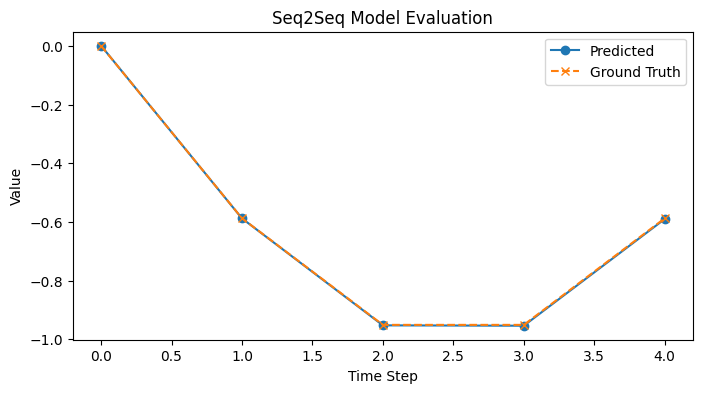

In [ ]:
# Switch the model to evaluation mode
seq2seq_model.eval()

# Choose a sample from the dataset (in practice we should probably use a separate test set)
sample_input, sample_target = dataset[0]
# Add batch dimension first
sample_input = sample_input.unsqueeze(0)

with torch.no_grad():
    # Get predictions for the defined future steps
    predicted_output = seq2seq_model(sample_input, future_steps)

# Remove extra dimensions and convert tensors to numpy arrays for plotting
predicted_output = predicted_output.squeeze().cpu().numpy()
sample_target = sample_target.squeeze().cpu().numpy()

# Plot the predicted vs. true values
plt.figure(figsize = (8, 4))
plt.plot(predicted_output, label = 'Predicted', marker = 'o')
plt.plot(sample_target, label = 'Ground Truth', marker = 'x', linestyle = '--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Seq2Seq Model Evaluation')
plt.legend()
plt.show()